In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import cv2
import sys
import os
import glob

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)
from sklearn.metrics import (cohen_kappa_score, confusion_matrix, classification_report, f1_score)

# For permutation tests
from sympy.utilities.iterables import multiset_permutations
from MulticoreTSNE import MulticoreTSNE as MTSNE

sys.path.insert(0, '../svs_reader/')
from normalize import reinhard

sys.path.insert(0, '../densenet_small')
from densenet_small import Inference

# config = tf.ConfigProto( device_count = {'GPU': 0} )
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
# labels = ['G3', 'G4', 'G5', 'BN', 'ST']
colors = [ '#af2108', '#149104', '#0ebbeb', '#0366a3']
labels = ['G3', 'G4/5', 'BN', 'ST']


SNAPSHOT = '../densenet_small/ext_75pct/snapshots/densenet.ckpt-99000'
height = width = 256
model = Inference(sess=sess, x_dims=(height, width, 3))
model.restore(SNAPSHOT)

image_in = model.x_in
bottleneck_op = model.intermediate_ops['05. Bottleneck']
yhat_op = model.y_hat

Requesting 4 dense blocks
MINIMIUM DIMENSION:  8
Setting up densenet in inference mode
DenseNet Model
Non-linearity: <function selu at 0x7f872e40df50>
	 x_in (?, 256, 256, 3)
Dense block #0 (dd)
	 Transition Down with k_out= 96
Dense block #1 (dd)
	 Transition Down with k_out= 144
Dense block #2 (dd)
	 Transition Down with k_out= 240
Dense block #3 (dense)
	 Bottleneck:  (?, 8, 8, 528)
	 Transition Up with k_out= 264
Dense block #0 (du)
	 Transition Up with k_out= 96
Dense block #1 (du)
	 Transition Up with k_out= 48
Dense block #2 (du)
Model output y_hat: (?, 256, 256, 5)
Restoring from ../densenet_small/ext_75pct/snapshots/densenet.ckpt-99000
INFO:tensorflow:Restoring parameters from ../densenet_small/ext_75pct/snapshots/densenet.ckpt-99000
Success!


## Populate a matrix of feature vectors

In [2]:
jpg_list = sorted(glob.glob('../data/val_jpg_ext/*.jpg'))
mask_list = sorted(glob.glob('../data/val_mask_ext/*.png'))
print(len(jpg_list), len(mask_list))

img_plotting = {}
img_classes = []
orig_imgs = []

z_vectors = []
y_vectors = []
idx = 0

# resize = 1.
resize = 0.5
# resize = 0.25
crop_size = int(height * (1/resize))
print(crop_size)

samples = 5
x0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)

x_y = [(x_, y_) for x_ in x0_vect for y_ in y0_vect]

coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
    x = reinhard(x)
#     x = cv2.imread(jpg, -1)
               
    for x0,y0 in x_y:
#         x0 = np.random.randint(0, 1200-crop_size)
#         y0 = np.random.randint(0, 1200-crop_size)
#         x0 = x0_vect[k]
#         y0 = y0_vect[k]
        
        ## Grab the majority label
        y_ = y[x0:x0+crop_size, y0:y0+crop_size]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        # Check for majority
        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (crop_size**2):
            # check for stroma -- two ways to skip stroma
            if maj==4 and totals[maj] < 0.95 * (crop_size*2):
                continue
#             elif maj==4 and np.random.randn(1) < 0.5:
#             elif maj==4 and np.random.choice([0,1], p=[0.1, 0.9]):
#                 continue
        else:
            continue

        img_classes.append(maj)
        orig_imgs.append(img_idx)
        
        idx += 1
        if idx % 500 == 0:
            print('{} [{} / {}]'.format(idx, img_idx, len(jpg_list)))
        x_ = x[x0:x0+crop_size, y0:y0+crop_size, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=resize, fy=resize)
#         x_ = x_ * (1/255.)
        x_ = x_ * (2/255.) - 1
        x_ = np.expand_dims(x_, 0)
        
        if np.random.randn() < -2:
            img_plotting[idx] = (x_ + 1)/2.
        
        z, yhat = sess.run([bottleneck_op, yhat_op], feed_dict={image_in: x_, model.keep_prob: 1.})
        ymax = np.argmax(yhat, axis=-1)
        num_classes = np.zeros(5)
        for ck in range(5):
            num_classes[ck] = (ymax==ck).sum()
        
        y_vectors.append(num_classes)
        
        z_int = np.mean(z, axis=(1,2))
        z_vectors.append(z_int)
        
    
z_vectors = np.concatenate(z_vectors, axis=0)

img_classes = np.asarray(img_classes)
orig_imgs = np.asarray(orig_imgs)
print('z vectors', z_vectors.shape)
print('img classes', img_classes.shape)
print('got classes:', np.unique(img_classes))

manifold = MTSNE(n_jobs=8, n_components=2, verbose=1)
z_manifold = manifold.fit_transform(z_vectors)
print('z manifold', z_manifold.shape)
# np.save('densenet_z_manifold_100pct', z_manifold)

print('Done')

538 538
512
500 [22 / 538]
1000 [44 / 538]
1500 [66 / 538]
2000 [86 / 538]
2500 [107 / 538]
3000 [127 / 538]
3500 [147 / 538]
4000 [167 / 538]
4500 [188 / 538]
5000 [208 / 538]
5500 [228 / 538]
6000 [248 / 538]
6500 [268 / 538]
7000 [288 / 538]
7500 [308 / 538]
8000 [328 / 538]
8500 [348 / 538]
9000 [368 / 538]
9500 [388 / 538]
10000 [411 / 538]
10500 [431 / 538]
11000 [451 / 538]
11500 [471 / 538]
12000 [491 / 538]
12500 [512 / 538]
13000 [536 / 538]
z vectors (13031, 528)
img classes (13031,)
got classes: [0 1 2 3 4]
z manifold (13031, 2)
Done


In [3]:
ymax = []
for yk in y_vectors:
    perm = np.argsort(yk)
    ym = perm[-1]
    
    if ym == 4: # stroma
        ypct = yk[ym] / float((height*width))
        if ypct < 0.9:
            ym = perm[-2]
            
    ymax.append(ym)
    
ymax = np.array(ymax)
print(ymax)

[4 4 4 ... 1 1 1]


## Classifier stuff

In [4]:
for k in range(5):
    print(k, np.sum(img_classes==k), np.sum(ymax==k))
    
print()

## Shift labels down 1:
img_classes[img_classes == 2] = 1
img_classes[img_classes == 3] = 2
img_classes[img_classes == 4] = 3

ymax[ymax == 2] = 1
ymax[ymax == 3] = 2
ymax[ymax == 4] = 3

for k in range(5):
    print(k, np.sum(img_classes==k), np.sum(ymax==k))

accuracy = (ymax==img_classes).mean()
print(accuracy)

0 748 1613
1 2075 2718
2 222 0
3 2687 4585
4 7299 4115

0 748 1613
1 2297 2718
2 2687 4585
3 7299 4115
4 0 0
0.7276494513084184


0
1
2
3


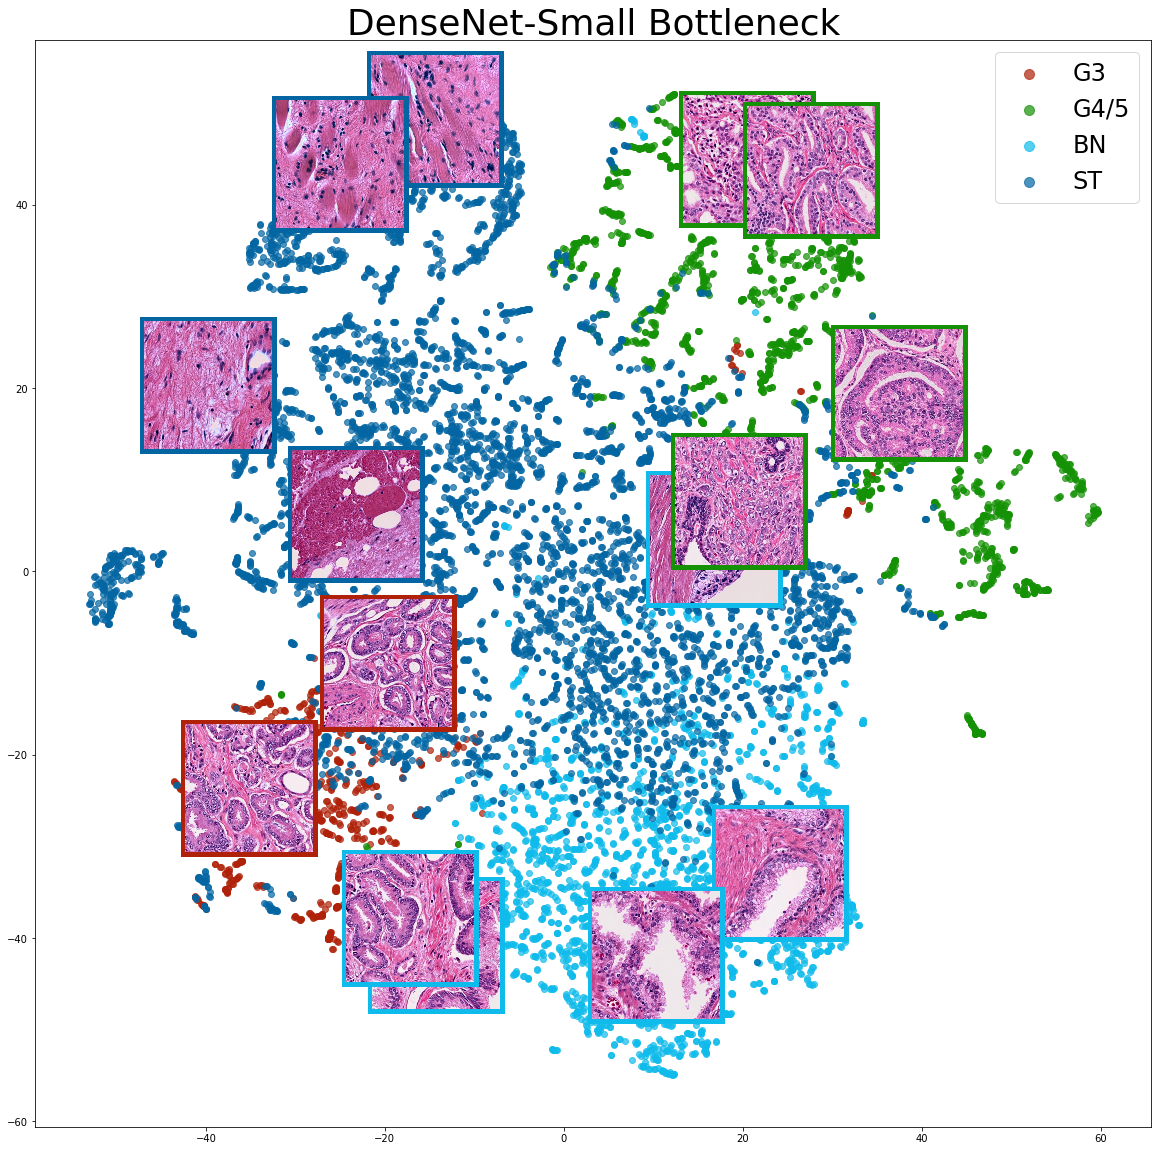

In [9]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
for k in range(4):
    print(k)
#     idx = ymax==k
    idx = img_classes==k
    sns.regplot(z_manifold[idx,0], z_manifold[idx,1], color=colors[k], label=labels[k],
                fit_reg=False, scatter_kws={'alpha': 0.7})
    
artists = []
indices = img_plotting.keys()
np.random.shuffle(indices)
boxprops={'ec': 'r'}

for k in indices[:15]:
#     imgy = img_classes[k]
    imgy = ymax[k]
    
    img_ = img_plotting[k]
    x,y = z_manifold[k]
    im = OffsetImage(np.squeeze(img_), zoom=0.5)
    ab = AnnotationBbox(im, (x,y), xycoords='data', pad=0.2, frameon=True, 
                        bboxprops={'ec': colors[imgy], 'lw': 5})
    artists.append(ax.add_artist(ab))
    
# plt.title('DenseNet-Small Bottleneck \n 75% Training Accuracy={:3.2f}%'.format(accuracy*100), fontsize=36)
plt.title('DenseNet-Small Bottleneck', fontsize=36)
lgnd = plt.legend(fontsize=24)
for k in range(4):
    lgnd.legendHandles[k]._sizes = [100]



In [13]:
fig.savefig('/home/nathan/Dropbox/_papers/gleason_grade/densenet_embedding_large_img.pdf', bbox_inches='tight')

In [ ]:
help(plt.scatter)

## Cluter the z vectors

In [ ]:
# Compare label assignments with the annotation
# clustered = clusterer.labels_

max_kappa = 0.0
max_f1 = 0.0
best_remapped = None

for vers in range(10):
    clusterer = MiniBatchKMeans(n_clusters=5, verbose=0, n_init=100).fit(z_vectors)
    clustered = clusterer.labels_
    
    for perm in multiset_permutations(range(5)):
        # Pick a mapping clustered --> labels
        mapping = {x: k for x, k in zip(range(5), perm)}

        clustered_remapped = np.asarray([mapping[y] for y in clustered])

        kappa = cohen_kappa_score(img_classes, clustered_remapped)
        f1 = f1_score(img_classes, clustered_remapped, average='weighted')
# 
#         print(vers, f1, max_f1)
#         if kappa > max_kappa:
        if f1 > max_f1:
            best_remapped = clustered_remapped
            max_kappa = kappa
            max_f1 = f1
            print(vers, kappa, f1)
            print(mapping)
            print(classification_report(img_classes, clustered_remapped), end='\n\n')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

for k in range(5):
    idxs = np.where(best_remapped==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], ax=axs[0])
    
    idxs = np.where(img_classes==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k], ax=axs[1])

axs[0].set_title('KMeans', fontsize=16)
axs[1].set_title('Labels', fontsize=16)
plt.legend(fontsize=12)
# plt.suptitle(u'{}\n$\kappa={:3.3f}$'.format(MODULE_NAME, max_kappa), fontsize=20)
plt.suptitle('{} (resize={})\nf1={:3.3f}'.format(MODULE_NAME, resize, max_f1), fontsize=20)
# plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_kmeans.pdf'.format(MODULE_NAME), bbox_inches='tight')